In [15]:
import os
import json
import io
from data_generator import DataGenerator
from trade_env import TraderEnv
from blog_ai import A3CAgent
from async_rl import *
import time
import numpy as np
from multiprocessing import *
from collections import deque
import matplotlib.pyplot as plt


In [16]:
stage_length_var = 10
def get_enviroment():
    return TraderEnv(DataGenerator(random=False, first_index=10170), stage_history_length=stage_length_var)

In [17]:
env = get_enviroment()

0 3 17341.72 17341.72 0  ---  17341.0 17341.72 0 0.01002
1 3 17341.72 17341.72 0  ---  17341.0 17341.72 0 0.010029999999999999
2 3 17341.72 17341.72 0  ---  17341.0 17341.72 0 0.010039999999999999
3 3 17341.72 17341.72 0  ---  17341.0 17341.72 0 0.010049999999999998
4 3 17341.72 17341.72 0  ---  17341.0 17341.72 0 0.010059999999999998
5 3 17341.72 17341.72 0  ---  17341.0 17341.72 0 0.010069999999999997
6 3 17341.72 17341.72 0  ---  17341.0 17341.72 0 0.010079999999999997
7 3 17341.72 17341.72 0  ---  17341.0 17341.72 0 0.007079999999999997
8 3 17341.0 17341.72 0  ---  17341.01 17341.72 0 0.004045401116390537
9 3 17341.72 17341.72 0  ---  17341.0 17341.72 0 0.004055401116390536
10 3 17341.72 17341.72 0  ---  17341.0 17341.72 0 0.004065401116390536
11 3 17341.72 17341.72 0  ---  17341.0 17341.72 0 0.004075401116390535
12 3 17341.72 17341.72 0  ---  17341.01 17341.72 0 0.004085401116390535
13 3 17341.72 17341.72 0  ---  17341.0 17341.72 0 0.004095401116390535
14 3 17349.55 17341.72 0  --

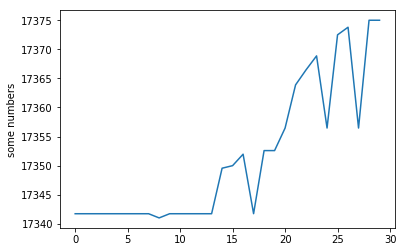

In [18]:
prices = []
env.step(1)
for i in range(30): 
    if i == 24:
        env.step(2)
    else:
        env.step(0)
    print(i, env._position, env.current["price"], env._entry_price, env._exit_price, " --- ",  env.get_order_sell_value(), env.get_order_buy_value(), env.total_profite, env._total_reward)
    prices.append(env.current["price"])
    
    
plt.plot(prices)
plt.ylabel('some numbers')
plt.show()

In [19]:
env._total_reward

157.39335371196412

In [10]:
argmax([0.2, 0.6, 0.7])

2